## Machine Learning project - Group A

# Forensic Identification of Glass Fragments

### Imports

In [24]:
# Imports from standard python libaries
import pandas as pd
import numpy as np
import scipy
import sys

import math 
import random

# Import for our exploratory data analysis
import seaborn as sns

# Imports for our pre-processing, reference implementation and last classification methods 
from sklearn.decomposition import PCA # Pre-processing, PCA-transformed data
from sklearn.model_selection import train_test_split # Splitting our data
from sklearn.preprocessing import MinMaxScaler # Normalizing our data

from sklearn.model_selection import validation_curve # To plot validation curve
import matplotlib.pyplot as plt # For plotting 
from sklearn import tree as sktree # For visualizing our decision tree

import tensorflow.keras as tf # Reference implementation for Neural Network
from sklearn.neural_network import MLPClassifier # Reference implementation for Neural Network
from sklearn.ensemble import RandomForestClassifier # Random forest
from sklearn.tree import DecisionTreeClassifier # Reference implementation for Decision Tree
from sklearn import svm # Support Vector Machine
from sklearn.neighbors import KNeighborsClassifier # KNN

import sklearn
from sklearn import metrics # For calculating accuracy score
from sklearn.metrics import f1_score # F1-score
from sklearn.model_selection import GridSearchCV # Used for choosing optimal hyper-parameters

from sklearn.metrics import plot_confusion_matrix # Plotting confusin matrices
from sklearn.metrics import ConfusionMatrixDisplay # Plotting confusion matrix

## Loading in the data

In [2]:
# Reading the data
train_df = pd.read_csv('df_train.csv')

# Mapping the labels to their namees
name_df = {1: '0: Window from building (float processed)', 2: '1: Window from building (non-float processed)', 
    3: '2: Window from vehicle', 5: '3: Container', 6: '4: Tableware', 7: '5: Headlamp'}
def name_map(number):
    return name_df[number]
print(name_map(2))

train_df['names'] = [name_map(i) for i in train_df['type']]
train_df

1: Window from building (non-float processed)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type,names
0,1.51839,12.85,3.67,1.24,72.57,0.62,8.68,0.00,0.35,2,1: Window from building (non-float processed)
1,1.52081,13.78,2.28,1.43,71.99,0.49,9.85,0.00,0.17,2,1: Window from building (non-float processed)
2,1.51708,13.72,3.68,1.81,72.06,0.64,7.88,0.00,0.00,2,1: Window from building (non-float processed)
3,1.52739,11.02,0.00,0.75,73.08,0.00,14.96,0.00,0.00,2,1: Window from building (non-float processed)
4,1.52210,13.73,3.84,0.72,71.76,0.17,9.74,0.00,0.00,1,0: Window from building (float processed)
...,...,...,...,...,...,...,...,...,...,...,...
144,1.51755,12.71,3.42,1.20,73.20,0.59,8.64,0.00,0.00,1,0: Window from building (float processed)
145,1.51800,13.71,3.93,1.54,71.81,0.54,8.21,0.00,0.15,2,1: Window from building (non-float processed)
146,1.52365,15.79,1.83,1.31,70.43,0.31,8.61,1.68,0.00,7,5: Headlamp
147,1.51571,12.72,3.46,1.56,73.20,0.67,8.09,0.00,0.24,1,0: Window from building (float processed)


### Loading the data as X_train and Y_train and normalizing the data (for M1 and M2)

In [3]:

def load_x(data):
    # Loading in the training data to a numpy array
    train_data = np.loadtxt('df_'+data+'.csv', skiprows=1, delimiter = ",")
    # Seperating the observations and the labels
    X_train = train_data[:,:9]
    Y_train = train_data[:,-1]


    return X_train

def load_y(data):
    """Loads the y-data, and reduces the values so that it goes from 0..6"""
    train_data = np.loadtxt('df_'+data+'.csv', skiprows=1, delimiter = ",", )
    Y_train = train_data[:,-1]
    Y_train -= 1 # Reduce all the classes by 1, so we start from 0
    # Reduce all the classes above class 3 by an additional 1 because we don't have a class 4
    Y_train[np.where(Y_train > 3)] -= 1

    return Y_train

# Applying the functions to our training data
x_train = load_x('train')
y_train = load_y('train')

# Applying the functions to our test data
x_test = load_x('test')
y_test = load_y('test')

# Normalizing our data using Sklearn

transformer = MinMaxScaler()
x_train = transformer.fit_transform(x_train)
x_test = transformer.transform(x_test)


### Making train/validation split


In [4]:
# Splitting our training data into training data and validation data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

### PCA transforming
Making a dataset that has been pca-transformed to test the effect on accuracy.


In [5]:
pca = PCA(n_components = 'mle')
pca_x_train = pca.fit_transform(x_train)
pca_x_val = pca.transform(x_val)

# Transforming the test-set
pca_x_test = pca.transform(x_test)

# Exploratory Data Analysis

First we will check for missing values

In [6]:
# Making sure there are no missing values
train_df.isnull().values.any()

False

In [7]:
# Exploring how many observations of each class is in our training data
train_df['type'].value_counts()

2    53
1    49
7    20
3    12
5     9
6     6
Name: type, dtype: int64

We can observe that type 2 is the most common class with 53 samples, while class 6 is the least common with only 6 samples.

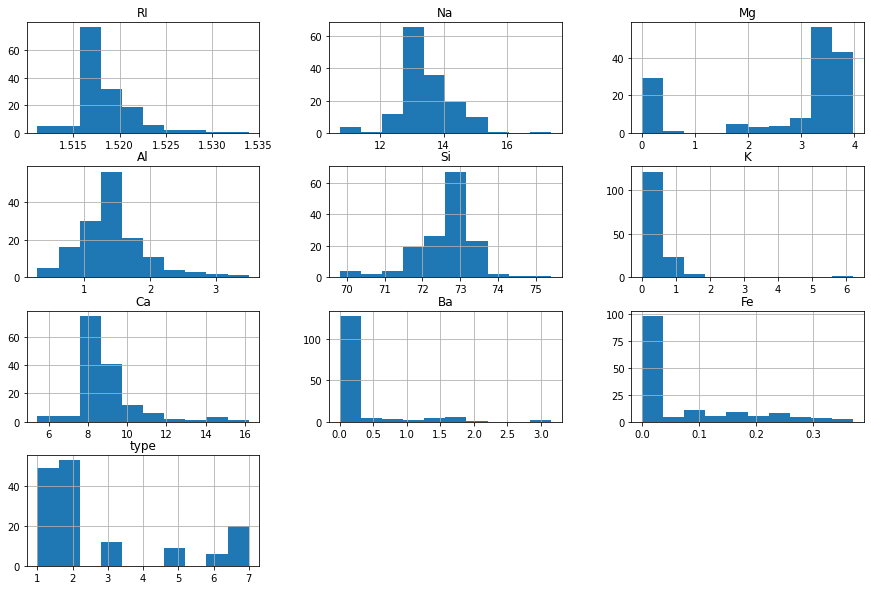

In [8]:
# Plotting the class distribution of each feature
train_df.hist(figsize=(15,10));

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


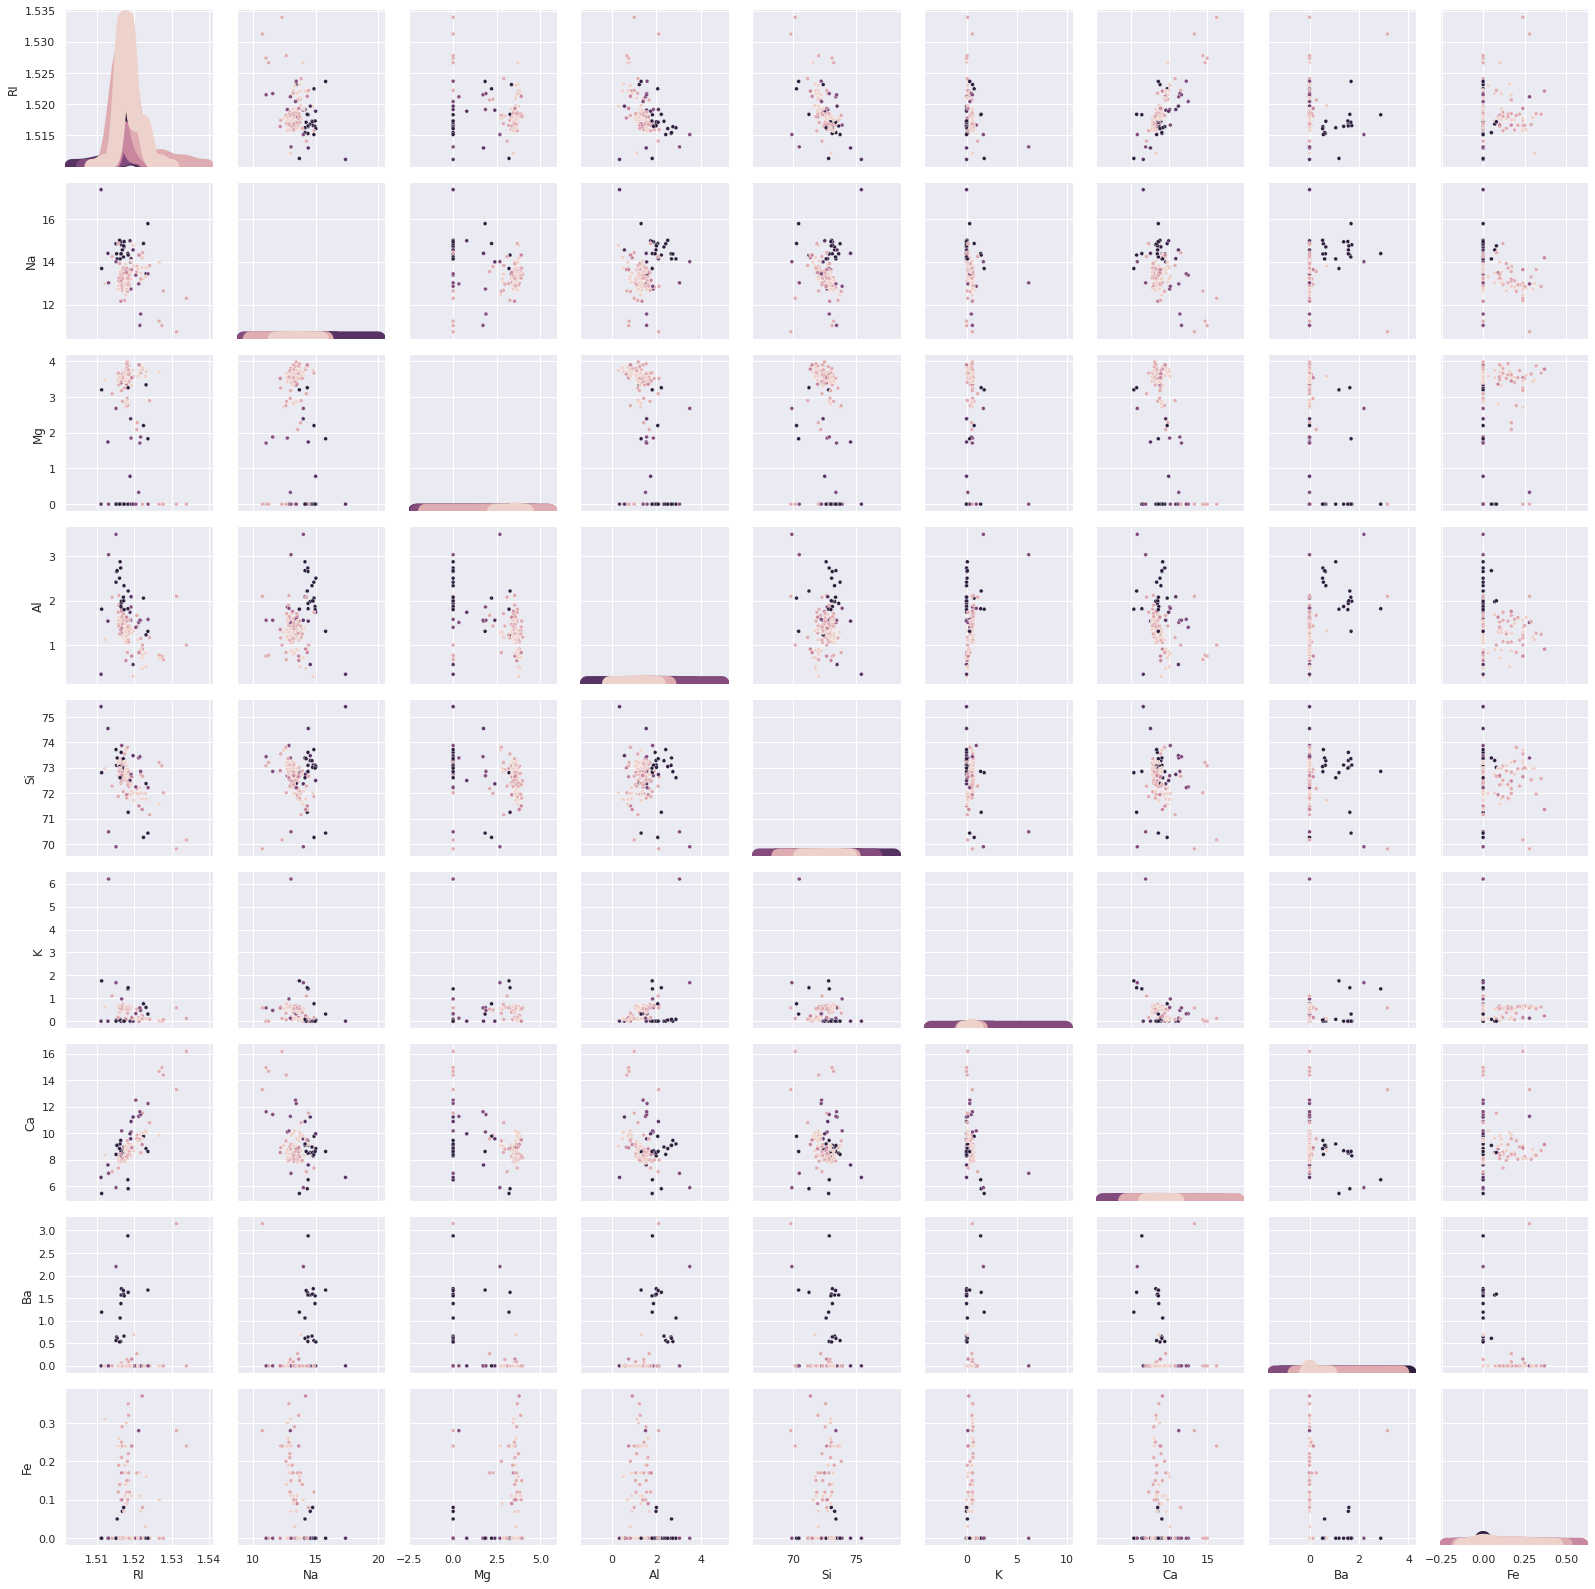

In [9]:
# Plottin the features pairwise
sns.set_theme()

plot = sns.PairGrid(train_df, hue = 'type')
plot.map_upper(sns.scatterplot, s=15)
plot.map_diag(sns.kdeplot, lw = 15)
plot.map_lower(sns.scatterplot, s= 15);

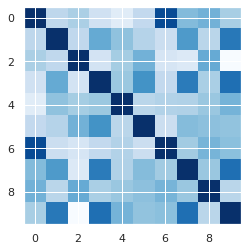

In [10]:
# Plotting the correlation of each pairwise feature
plt.imshow(train_df.corr(), cmap='Blues');

### Calculating the correlation between the features

In [11]:
# Calculating the correlation between all features
c = train_df.corr().abs()
print(c)

            RI        Na        Mg        Al        Si         K        Ca  \
RI    1.000000  0.260584  0.156225  0.393512  0.541810  0.288022  0.815106   
Na    0.260584  1.000000  0.271648  0.160512  0.030542  0.212932  0.349449   
Mg    0.156225  0.271648  1.000000  0.424156  0.126577  0.098270  0.447793   
Al    0.393512  0.160512  0.424156  1.000000  0.074505  0.338642  0.288594   
Si    0.541810  0.030542  0.126577  0.074505  1.000000  0.241871  0.198236   
K     0.288022  0.212932  0.098270  0.338642  0.241871  1.000000  0.357690   
Ca    0.815106  0.349449  0.447793  0.288594  0.198236  0.357690  1.000000   
Ba    0.023676  0.282964  0.502356  0.490822  0.185238  0.016004  0.112389   
Fe    0.097121  0.238313  0.154060  0.151610  0.072297  0.014780  0.081924   
type  0.143319  0.516490  0.739495  0.572615  0.086451  0.037192  0.010639   

            Ba        Fe      type  
RI    0.023676  0.097121  0.143319  
Na    0.282964  0.238313  0.516490  
Mg    0.502356  0.154060  0.73

This shows that the most correlated features are RI and Ca with 81.5%. 

### Barplot of the distribution of each class with their glass fragment description

[Text(0, 0, '0: Window from building (float processed)'),
 Text(1, 0, '1: Window from building (non-float processed)'),
 Text(2, 0, '2: Window from vehicle'),
 Text(3, 0, '3: Container'),
 Text(4, 0, '4: Tableware'),
 Text(5, 0, '5: Headlamp')]

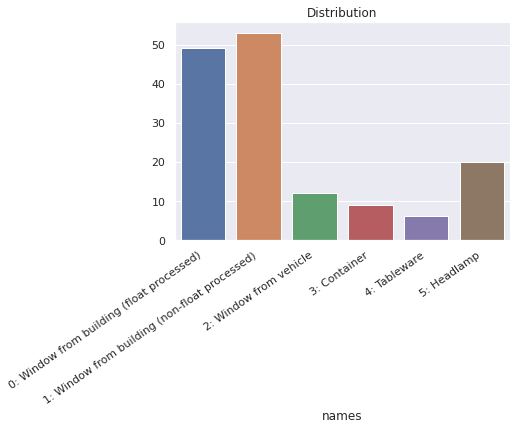

In [12]:
freq = train_df[['names']].groupby('names').size()
plt = sns.barplot(x = freq.index, y = freq)
plt.set_title('Distribution')
plt.set_xticklabels(plt.get_xticklabels(), 
                          rotation=35, 
                          horizontalalignment='right')

[Text(0, 0, '1'),
 Text(1, 0, '2'),
 Text(2, 0, '3'),
 Text(3, 0, '5'),
 Text(4, 0, '6'),
 Text(5, 0, '7')]

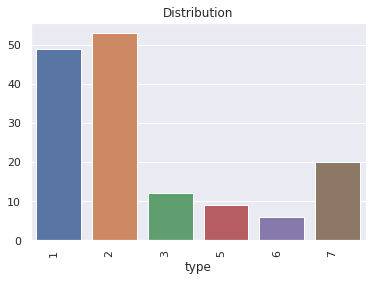

In [13]:
# Making a barplot of the distribution of each class with their original label

freq = train_df[['type']].groupby('type').size()
pl = sns.barplot(x = freq.index, y = freq)
pl.set_title('Distribution')
pl.set_xticklabels(pl.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')

### PCA 
Plot of PCA1 and PCA2.

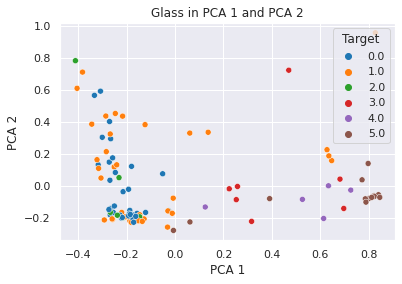

In [14]:
pca_2_dim = pca_x_train[:,:2]
pca_df = pd.DataFrame(pca_2_dim, columns = ['PCA 1', 'PCA 2'])
pca_df['Target'] = y_train
pca_df
ax = sns.scatterplot(data = pca_df, x = 'PCA 1', y = 'PCA 2', hue = 'Target', palette='tab10')
ax.set_title('Glass in PCA 1 and PCA 2');

# M1 (classification method 1)
### Decision Trees

In [15]:

class decision_tree:
    """Creating the paretn class of the tree. This class hold the variables for the tree, and is the interface. 
    It has the functions fit, that create the root node in the tree, that it remembers, and wich recursively creates the tree
    predict_proba returns a probability vector for every observation given, where each row sums to 1. 
    predict returns a single vetor with the class with the highest probabilty. 
    All gini is called gino. This is an inside joke, as our friend is named gino."""
    def __init__(self, max_splits, min_gino, min_samples_split, min_gino_improvement):
        self.max_splits = max_splits # Determins the depth of the tree.
        self.min_gino = min_gino # Determins the minimum gin. Not used any more
        self.min_leaf_size = min_samples_split # The minimal size a leaf needs to have to be created
        self.min_gino_improvement = min_gino_improvement # The minimal improvement in gino a leaf have to have to be accepted
    
    def fit(self, x, y):
        """Function that fits the model to the features x and the classes y"""
        self.first_leaf = leaf(x, y, layer = 0, min_gino = self.min_gino, max_depth = self.max_splits, min_leaf_size = self.min_leaf_size, min_gino_improvement = self.min_gino_improvement)
    


    def predict_proba(self, x):
        """Function that returns a probability vector for each row in x """
        predictions = []
        for row in x:
            predictions.append(self.first_leaf.predict(row))
        return np.array(predictions)

    def predict(self, x):
        """Function that returns the class with the highest probability """
        predictions = []
        for row in x:
            predictions.append(self.first_leaf.predict(row))
        predictions = np.array(predictions)
        return np.argmax(predictions, axis = 1) # Returning the index or class of each row.



class leaf():
    
    def __init__(self, x, y, layer = 0, min_gino = 0.7, max_depth = 10, min_leaf_size = 10, min_gino_improvement = 1):
        """Function that create a new leaf."""
        self.layer = layer # Marking the depth of the leaf
        self.leaf_node = True # Making a variable to see, if the node have children of if it is a leaf.
        self.min_gino = min_gino 
        self.max_splits = max_depth
        self.min_leaf_size = min_leaf_size
        self.min_gino_improvement = min_gino_improvement

        self.leaf_gino = self.find_spicific_gino(y) # finding gini impurity for 
        if self.leaf_gino == 0: # If the leaf is pure, it is marked as a return-leaf, and will not create any children
            self.return_probability = self.make_probability_vector(y) # Save the return-propability
            return
        if layer != self.max_splits and len(y) > min_leaf_size*2+1: # Using the conditions that the current layer needs to be
            # less then the given maximum, and that there are enough data to create two new leafs.  
            coifficient, split_value, split_coloumn = self.find_optimal_split(x, y) # finding the best split, and saving the 
            #  coloumn it splits on, the value it splits on, and the coifficient of the two new leafs combined.
            if coifficient < self.min_gino and coifficient < self.leaf_gino*min_gino_improvement: # If the split is pure enough
                fulfills_condition = x[:,split_coloumn] > split_value # Create a list of bools for which values lives up to conditions
                # Make children that lives up to conditions
                self.left_leaf = leaf(x[fulfills_condition,:], y[fulfills_condition], layer = self.layer + 1, min_gino= min_gino, max_depth = self.max_splits, min_leaf_size = min_leaf_size) 
                self.right_leaf = leaf(x[ ~ fulfills_condition, : ], y[~ fulfills_condition], layer = layer + 1, min_gino= min_gino, max_depth = self.max_splits, min_leaf_size = min_leaf_size)
                


                # Save conditions as variables for prediction of new values.
                self.cutoff_value = split_value
                self.dicision_coloumn = split_coloumn
                self.leaf_node = False # Marking, that the node have children for when the model predicts. 
                return 
        
        self.return_probability = self.make_probability_vector(y) # If the node does not live up to the condition, it is a leaf.
            # It should then return the probability vector when making predictions.




    def make_probability_vector(self, y):
        """Create the probability vector for the node as p(k) = sum(y == k)/len(y) """
        probability_vector = np.zeros(6) # Making a vector for each of the values
        for i in y:
            probability_vector[int(i)] += 1 # Incrementing the counter for every class
        probability_vector /= len(y) # Normalizing the probability-vector
        return probability_vector



    def find_optimal_split(self, x, y):
        """ A function that takes the x and y-values, and returns the gini-impurity of the best split, the split value 
        and the split coloumn. It finds the best value by considering every posible split, finding the impurity for it,
        and then returning the parameters of the split with the lowest impurity"""
        best_gino = np.inf # Mark the starting split so all splits will get better value
        split_value = None
        split_coloumn = None
        for coloumn in range(x.shape[1]):
            splits = self.find_posible_splits(x[:,coloumn]) # Finding all posible split values in axis i
            for split in splits: # Looping over every split value for the axis i
                larger = [x[:, coloumn] > split] 
                smaller = [x[:, coloumn] <= split]
                gino = self.find_gino([y[larger], y[smaller]]) # Finding the gini-impurtiy for the classes that fullfills 
                # and don't fulfills the condition
                if gino < best_gino: # If split have lower impurity, it is saved.
                    best_gino = gino
                    split_value = split
                    split_coloumn = coloumn
        return best_gino, split_value, split_coloumn



    def find_posible_splits(self,coloumn):
        """A funciont that gets a vector of values, and returns all posible split-values. The split-values are
        the mean of two adjacent values. """
        sorted_values = np.sort(coloumn) # Sort to find adjacent. Allows for multiple of the same value, as some coloumns have
        # many observations with equal value.

        # Making 2 vectors from the sorted values shifted by 1, and from the minimum index of the minimal leaf size, to the
        # maximum value of the maximum leaf size. Adding the two vectors together, to find their mean
        arverage_split = sorted_values[self.min_leaf_size : -(self.min_leaf_size + 1)] + sorted_values[self.min_leaf_size+1 : - self.min_leaf_size]
        arverage_split =  arverage_split / 2 # Finding the mean of all the neigbouring values
        return np.unique(arverage_split) # Returns only the unique values, to avoid redundand work


    def find_gino(self, partitionings): # Easter egg for a friend
        """Takes a list of vectors with class labels, and returns the gini impurity of it."""
        impurity = np.array([0.0,0.0]) #Initialize the impurty of each node
        n = len(partitionings[0])+len(partitionings[1]) # saving the number of nodes in total
        fraction_size = np.array([len(partitionings[0])/n,len(partitionings[1])/n]) # Finding the ammount that is in the left and right node. 
        for number, side in enumerate(partitionings): 
            impurity[number] = self.find_spicific_gino(side) #Finding the impurtiy for each side
            
        impurity = impurity[0]*fraction_size[0] + impurity[1] * fraction_size[1] # Creating the weighted gini impurity
        return impurity / len(partitionings) 




    def find_spicific_gino(self, side):
        """Takes a list of class values, and return the gini-impurtiy for the list 
        Found as 1 - sum(p(k)^2) for all classes k"""
        gini = 1
        for key in np.unique(side): # Itterating over each class
            gini -= (sum(side == key) / len(side))  **2 # Finding purty for each class, and subtracting it from 1. 
        return gini



    def predict(self, x):
        """This function returns the probability for each class if it is a leaf-node,
        or returns the probability of the children if it is not"""
        
        if self.leaf_node: # Check if the node is a leaf-node
            return self.return_probability # If node is a leaf_node, return the probability vector
 
        # If node is not a leaf:
        if x[self.dicision_coloumn] > self.cutoff_value: # Make the right child determin the prediction recursivly.
            return self.left_leaf.predict(x)
        else:
            return self.right_leaf.predict(x)



### Reference implementation - M1

In [16]:
max_depth = [3, 5, 7, 10]
min_samples_split= [3, 8, 15]
min_gino_improvement = [1, 0.8, 0.5]
best_prediction = 0
best_correct = 0
performance = []
# Manual gridserch for optimal hyperparameters.
for depth in max_depth:
    for splits in min_samples_split:
        for improvement in min_gino_improvement:
            tree = decision_tree(min_gino = 3, max_splits = depth, min_samples_split = splits, min_gino_improvement = improvement)
            tree.fit(x_train, y_train)
            predictions = tree.predict(x_val)
            right = f1_score(y_val, predictions, average = 'macro')
            if right > best_prediction:
                best_prediction = right
                prediction_perameters = [depth, splits, improvement]
            pre_tree = DecisionTreeClassifier(max_depth = depth, min_samples_split = splits, random_state= 42)
            pre_tree.fit(x_train, y_train)
            predictions = pre_tree.predict(x_val)
            correct = f1_score(y_val, predictions, average = 'macro')

            if correct > best_correct:
                best_perameters = [depth, splits]
                best_correct = correct

            performance.append([right, correct])

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:97: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:97: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:97: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.arr

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:97: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Hand build accuracy =  0.6153846153846154
Hand build f1_score =  0.5217756747989306
Pre-build f1_score =  0.7520692761994137
Pre-build accuracy =  0.7692307692307693
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


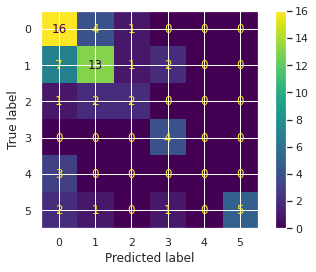

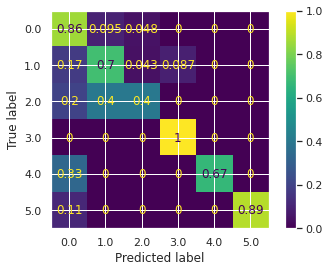

In [17]:
tree = decision_tree(max_splits= prediction_perameters[0], min_gino = 3, min_samples_split= prediction_perameters[1], min_gino_improvement= prediction_perameters[2])
tree.fit(x_train, y_train)
prediction = tree.predict(x_test)
print('Hand build accuracy = ',sum(prediction == y_test)/len(y_test))
print('Hand build f1_score = ', f1_score(y_test, prediction, average = 'macro'))
confusion = np.zeros((6,6))
for i in range(len(prediction)):
    confusion[int(y_test[i])][int(prediction[i])] += 1

confusion = ConfusionMatrixDisplay(confusion_matrix=confusion)
confusion.plot()


pre_tree = DecisionTreeClassifier(max_depth = best_perameters[0], min_samples_split = best_perameters[1], random_state= 42)
pre_tree.fit(x_train, y_train)
predictions = pre_tree.predict(x_test)
print('Pre-build f1_score = ', f1_score(y_test, predictions, average = 'macro'))

print('Pre-build accuracy = ',sum(predictions == y_test)/len(y_test))
plot_confusion_matrix(pre_tree, x_test, y_test, normalize = 'true');


#### Visualization of the Decision Tree
Using "pre_tree", hence, it is the reference implemented Decision Tree made with Scikit-learn.

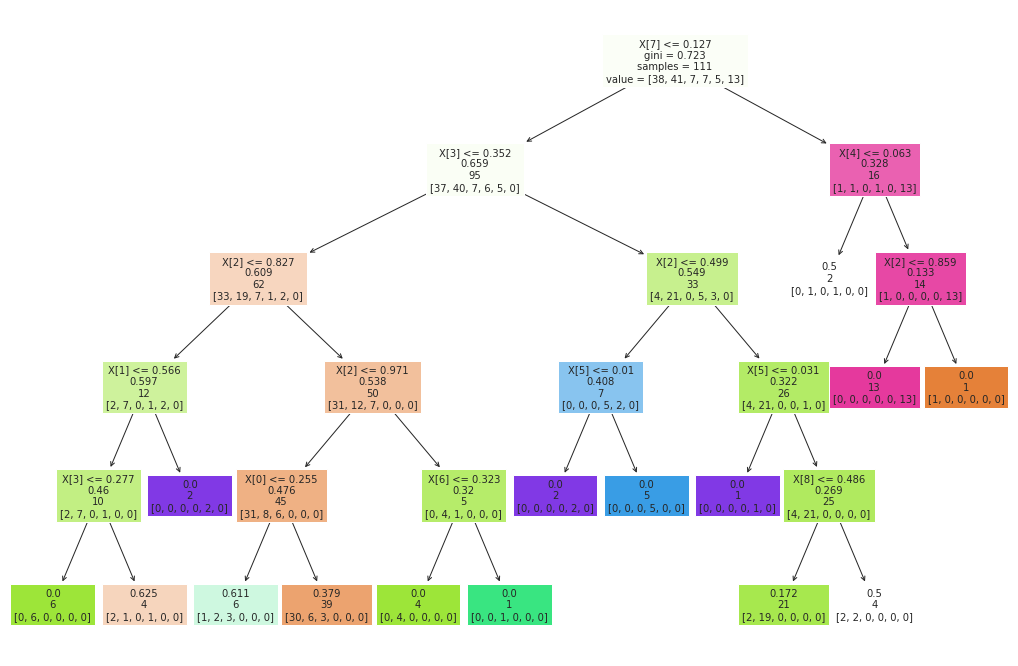

In [18]:
import matplotlib.pyplot as plt # For some reason we need this line to not get an error???
plt.figure(figsize=(18,12))
sktree.plot_tree(pre_tree, fontsize= 10, label= 'root', filled= True)
plt.show()

# M2 (classification method 2)
### Feed-forward Neural Networks

In [37]:
class Neuron:

    def __init__(self,num_in):
        num_in = num_in + 1 # Adding bias to the weight
        self.weights = np.random.uniform(-1,1,size=(num_in,1))
        
    
    def forward(self,x):
        
        x = np.concatenate((x,[[1]]),axis=1) # Adding a 1 to the vector for the bias
            
        self.x = x # Saving the incomming data for the backpropogation
        return np.matmul(x,self.weights) #Returning the weight of the neuron by multiplying the incomming vector with the weights and bias
                                
    def backward(self,gradient_l): 
        """Function that takes the loss-vector of the previous layer, and returns the loss-vector for this layer, as well as the gradient for theis layer """
        self.gradient_x = self.weights.transpose()*gradient_l
        self.gradient_w = self.x.transpose()*gradient_l
        return self.gradient_x,self.gradient_w
        

class ReLu:

    def __init__(self):
        self.gradient = None
        self.x = None
    
    def forward(self,x):
        """Implements forwar-propagation for a single neuron """
        self.x = x
        if x > 0:
            return x
        else:
            return 0
    
    def backward(self,gradient_l=1):
        """Implements backpropagation for  relu for a singel neuron"""
        
        if self.x > 0:
            self.gradient = gradient_l # Gradient is linear
            return gradient_l
        else:
            self.gradient = sys.float_info.epsilon # Gradiant ecual to lowest posible value
            return np.array([[sys.float_info.epsilon]])   
        
            


class CE:

    def __init__(self):
        self.gradient = None
        self.y = None
        self.y_hat = None
        
    def forward(self,y_hat,y):
        """Finding the cost of the prediction with as the negative sum the right probability """
        self.y_hat = y_hat
        self.y = y # Saving y and y-hat for backpropagation
        return -np.sum(y_hat*y)
    
    def backward(self,gradient_l=1):
        """Function to find the gradient of the cost-function."""
        self.gradient = -self.y*1/np.maximum(sys.float_info.epsilon,self.y_hat)
        return self.gradient
        
            
        
    def __str__(self):
        return "loss"

class softmax:

    def __init__(self):
        """Initializing the class"""
        self.gradient = None
        self.prev_x = None
        self.forward_x = None


    def forward(self,prev_x):
        """Function that implements a softmax activation for an vector """
        self.prev_x = prev_x
        self.forward_x = np.exp(prev_x)/np.sum(np.exp(prev_x))
        return self.forward_x
    
    def backward(self,gradient_l=None):
        """Returns the loss for the softmax function """    
        p1 = self.forward_x*(1-self.forward_x)
        self.gradient = -1*np.matmul(self.forward_x.transpose(),self.forward_x)
        np.fill_diagonal(self.gradient,p1)
        self.gradient = np.expand_dims(np.sum(self.gradient*gradient_l,1),0)
        return self.gradient

    def __str__(self):
        return "softmax"
        
class neural_layer:

    def __init__(self,input_= 1,output_= 1):
        """Create a neural layer """
        self.output_size = output_ # Number of neurons to use in the Neural Network layer
        self.input_size = input_ # Number of features we're giving the training 
        self.neurons = [Neuron(input_) for _ in range(output_)]
        
    def forward(self,x):
        """Forwards-propagate through a single layer by looping over all the neurons  """
        outputs = [neuron.forward(x) for neuron in self.neurons]
        return np.concatenate(outputs,1)
    
    def backward(self,gradient_l=None):
        """Function that back-propigate. Takes the gradient from the activation function before, 
        and return a touple if the gradient of the function, as well as the loss-vector """
        weight_gradients = []
        input_gradient = 0
        gradient_l = gradient_l.squeeze(0)  
        
        for i,neuron in enumerate(self.neurons):
            temp_gradient = neuron.backward(gradient_l[i]) #Finding the loss-vecotr for the current function.
            weight_gradients.append(temp_gradient[1]) # Finding the gradient of the function
            input_gradient = input_gradient + temp_gradient[0] # Finding the loss-vector for the previus function
            
        gradients = (input_gradient,weight_gradients)
                    
        return gradients
    
    def __str__(self):
        return "neuron"
class relu_layer:

    def __init__(self,output_= 1):
        """ Create a relu function for every neuron"""
        self.output_size = output_
        self.activations = [ReLu() for _ in range(output_)]


    def forward(self,x):
        """Function that does chooses max(x, 0) for all rows in the vector"""
        output = []
        x = x.squeeze(0)
        for i,activation in enumerate(self.activations): #iterating over all neurons with relu function
            output.append(activation.forward(x[i]))
        return np.expand_dims(output,0)
    
    def backward(self,gradient_l=None):
        """Getteing the error-vector for all neurons based on the previus layers error-vector """
        gradients = []
        gradient_l = gradient_l.squeeze(0)     
                
        
        for i,activation in enumerate(self.activations):
            gradients.append(activation.backward(gradient_l[i]))
            
        return np.expand_dims(gradients,0)
    
    def __str__(self):
        return "relu"

class neural_network:
    """Inspired by mlpotter from https://github.com/mlpotter/Neural-Network-Numpy/blob/master/NeuralNetworks.ipynb """


    def __init__(self,model=[]):         
        """Function that takes the neural and activation layers and saves them as the model. """
        self.model = model
        self.gradients = []


    def fit(self, x_values, y_values, epocs):
        """ Function that runs the training loop for the nn. Takse x, y and training epocs, and trains the network"""
        for i in range(epocs):
            mean_loss = []
            for x,y in zip(x_values,y_values):
                x = np.expand_dims(x,0)
                
                # forward pass
                output = nn.forward(x)
                loss = loss_fn.forward(output,y)
                mean_loss.append(loss)

                # backward pass
                loss_back = loss_fn.backward()
                nn_back = nn.backward(loss_back)

                # update weights based on gradient
                optimize.step()
            
            if i % print_every == 0:
                print("epoch {}: loss = {}".format(i,np.mean(mean_loss)))


    def predict(self, x):
        """A function that predicts the class k with the highest probability for every input y """
        prediction = []
        for i in x:
            i = np.expand_dims(i,0)
            guess = self.forward(i)
            prediction.append(np.argmax(guess))
        return prediction
    
    def predict_proba(self, x):
        """A function that returns the probability vector for every class for each row of x """
        prediction = []
        for i in x:
            i = np.expand_dims(i,0)
            prediction.append(self.forward(i))
        return prediction
        
    def forward(self,x):
        """ Do a forward propagation for at single x in the model"""
        for layer in self.model:
            x = layer.forward(x)    
        return x
    
    def backward(self,gradient_l=None):
        """ Does backpropogation through the model, by finding the gradiant for each layer."""
        self.gradients = []
        for layer in self.model[::-1]:
            if str(layer) == "relu":
                tup = ("relu",layer.backward(gradient_l))
                self.gradients.append(tup)
                gradient_l = tup[1]
            
            elif str(layer) == "neuron":
                tup = ("neuron",layer.backward(gradient_l))
                self.gradients.append(tup)                
                gradient_l = tup[1][0]
                
            elif str(layer) == "softmax":
                tup = ("softmax",layer.backward(gradient_l))
                self.gradients.append(tup)
                gradient_l = tup[1]

        self.gradients = self.gradients[::-1]
        return self.gradients
    
    def get_weights(self):
        """Function that returns all weights in each layer """
        weights = []
        layer_num = 0
        for layer in self.model:
            if str(layer) == 'neuron':
                layer_weights = []
                for neuron in layer.neurons:
                    layer_weights.append(neuron.weights)
                weights.append(('layer'+str(layer_num),layer_weights))
                layer_num += 1
        return weights
        
class optimizer:
    
    def __init__(self,model = None,alpha=0.05):
        """ Function that saves the model and the learning rate"""
        self.model = model
        self.loss_fn = loss_fn
        self.alpha = alpha

    def step(self):
        """ Function that updates the weights in each layer."""
        for obj,grad in zip(self.model.model,self.model.gradients): # Looping over the layers and their gradiats
            if grad[0] == 'neuron': # Only updates the values if it is a neuron, and not for the activation function
                for n,grad_update in zip(obj.neurons,grad[1][1]): # Looping over the neurons in the layer, and the gradiant value
                    n.weights = n.weights - self.alpha*grad_update # Updating the values

In [38]:
y_hot = y_train.astype(int)
y_hot = np.eye(y_hot.max()+1)[y_hot]
y_test_hot = y_train.astype(int)
y_test_hot = np.eye(y_test_hot.max()+1)[y_test_hot]

In [71]:
random.seed = 1
model = [neural_layer(9,10),relu_layer(10),neural_layer(10,10),relu_layer(10),neural_layer(10,6),softmax()]
nn = neural_network(model)
loss_fn = CE()

alpha = 0.05
optimize = optimizer(nn,alpha)
print_every = 5

nn.fit(x_train, y_hot, 40)

/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
epoch 0: loss = -0.27642208057652107
epoch 5: loss = -0.414375500169703
epoch 10: loss = -0.46119056672733394
epoch 15: loss = -0.4838506058938328
epoch 20: loss = -0.5106798440576765
epoch 25: loss = -0.5224902600230881
epoch 30: loss = -0.5387580798415414
epoch 35: loss = -0.5498338649623297


Accuracy score - our Neural Network: 0.6
F1-score: 0.5401234567901235


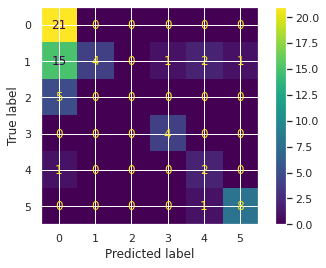

In [73]:
fnn_prediction = nn.predict(x_test)
fnn_score = metrics.accuracy_score(y_test,fnn_prediction)
print('Accuracy score - our Neural Network:',fnn_score)
print('F1-score:',f1_score(y_test, fnn_prediction, average = 'macro'))

# Plotting confusion matrix
fnn_confusion = np.zeros((6,6))
for i in range(len(fnn_prediction)):
    fnn_confusion[int(y_test[i])][int(fnn_prediction[i])] += 1

fnn_confusion = ConfusionMatrixDisplay(confusion_matrix=fnn_confusion)
fnn_confusion.plot()

### Reference implementation - M2

Using Sklearn's library to make a reference implementation of M2 and GridSearchCV to find optimal hyperparameters.

In [29]:
# Making a classifier and setting the random state
mlp_gs = MLPClassifier(random_state= 42)

# Building the parameters
parameter_space = {
    'hidden_layer_sizes': [(10,10,10),(20,30,10)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam','lbfgs'],
    'alpha': [0.1,0.0001, 0.05, 4.0],
    'learning_rate': ['constant','adaptive'],
}

# Searching for the best parameters
mlp_clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)

# Training the model on our training data 
mlp_clf.fit(x_train, y_train)

# Making a prediction on our validation data
y_nn_pred = mlp_clf.predict(x_val)

# Calculating the accuracy score
nn_score = metrics.accuracy_score(y_val,y_nn_pred)

best_parm = mlp_clf.best_params_
print(best_parm)


{'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (10, 10, 10), 'learning_rate': 'constant', 'solver': 'lbfgs'}
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
F1-score: 0.44945533769063184
Neural Network - Accuracy score: 0.6461538461538462


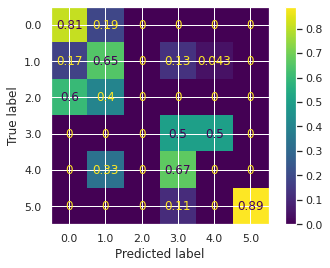

In [30]:
mlp = MLPClassifier(activation = 'relu', alpha = 0.1, hidden_layer_sizes = (10,10,10), learning_rate = 'constant', solver = 'lbfgs', random_state= 42)
mlp.fit(x_train,y_train)
y_mlp = mlp.predict(x_test)
mlp_score = metrics.accuracy_score(y_test,y_mlp)
print('F1-score:',f1_score(y_test, y_mlp, average = 'macro'))
print('Neural Network - Accuracy score:',mlp_score)
ax = plot_confusion_matrix(mlp, x_test, y_test, normalize='true');


Now we will try to use the PCA-transformed data to see if it gives better results. 

In [55]:
# Making a classifier and setting the random state
mlp_gs = MLPClassifier(random_state= 42)

# Building the parameters
parameter_space = {
    'hidden_layer_sizes': [(10,10,10),(20,30,10)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam','lbfgs'],
    'alpha': [0.1,0.0001, 0.05, 4.0],
    'learning_rate': ['constant','adaptive'],
}

# Searching for the best parameters
mlp_clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)

# Training the model on our training data 
mlp_clf.fit(pca_x_train, y_train)

# Making a prediction on our validation data
y_nn_pred = mlp_clf.predict(pca_x_val)

# Calculating the accuracy score
nn_score = metrics.accuracy_score(y_val,y_nn_pred)

best_parm = mlp_clf.best_params_
print(best_parm)


{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (10, 10, 10), 'learning_rate': 'constant', 'solver': 'lbfgs'}
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
F1-score: 0.5808563038742066
Neural Network - Accuracy score: 0.7076923076923077


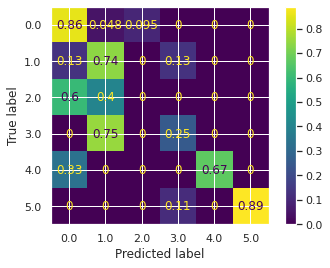

In [74]:
mlp = MLPClassifier(activation = 'relu', alpha = 0.05, hidden_layer_sizes = (10,10,10), learning_rate = 'constant', solver = 'lbfgs', random_state= 42)
mlp.fit(pca_x_train,y_train)
y_mlp = mlp.predict(pca_x_test)
mlp_score = metrics.accuracy_score(y_test,y_mlp)
print('F1-score:',f1_score(y_test, y_mlp, average = 'macro'))
print('Neural Network - Accuracy score:',mlp_score)
ax = plot_confusion_matrix(mlp, pca_x_test, y_test, normalize='true');


The PCA-transformed data yields better results. 

##### Keras

In [75]:
#https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

model = keras.Sequential()
model.add(layers.Dense(12, input_dim=9, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='relu' ))

model.compile(optimizer ='adam',loss='categorical_crossentropy', metrics =['accuracy'])

model.fit(x_train,y_train)

_, accuracy = model.evaluate(x_val, y_val)
print('Accuracy: %.2f' % (accuracy*100))

2/2 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.2895
Accuracy: 28.95


Keras's library does not give better results than the Sci-kit learn's library.

# Random Forest - M3

We will use Sklearn's library to implement Random Forest classifier. Additionally, we are using GridSearchCV to obtain the optimal hyperparameters.

In [76]:
params = {'n_estimators' : [10, 100],
            'max_depth' : [3, 5, 10],
            'min_impurity_decrease' : [0, 0.05, 0.1],
            'bootstrap' : [True, False],
            'random_state' : [42]}
 
forrest_grid = GridSearchCV(RandomForestClassifier(), params)
 
# Fitting the model for grid search
forrest_ = forrest_grid.fit(x_train, y_train)

forrest_y = forrest_.predict(x_val)

forrest_acc_score = metrics.accuracy_score(y_val,forrest_y)
# Print best parameter after tuning
best_parm = forrest_.best_params_
print(best_parm)

{'bootstrap': True, 'max_depth': 10, 'min_impurity_decrease': 0, 'n_estimators': 10, 'random_state': 42}


Forest - Accuracy score: 0.7538461538461538
F1-score: 0.6659412447455926
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


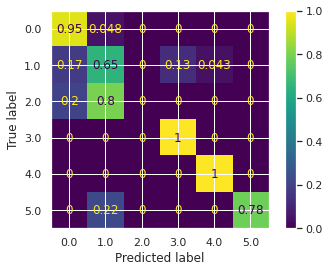

In [77]:
f_clf = RandomForestClassifier(bootstrap=True, max_depth=10, min_impurity_decrease=0, n_estimators=10, random_state=42)

f_clf.fit(x_train, y_train)

fy_pred = f_clf.predict(x_test)

f_accuracy_score = metrics.accuracy_score(y_test, fy_pred)

print('Forest - Accuracy score:',f_accuracy_score)
print('F1-score:',f1_score(y_test, fy_pred, average = 'macro'))
# Plotting confusion matrix
ax = plot_confusion_matrix(f_clf, x_test, y_test, normalize='true')


Now we will try to use the PCA-transformed data to see if it gives better results. 

In [78]:
params = {'n_estimators' : [10, 100],
            'max_depth' : [3, 5, 10],
            'min_impurity_decrease' : [0, 0.05, 0.1],
            'bootstrap' : [True, False],
            'random_state' : [42]}
 
forrest_grid = GridSearchCV(RandomForestClassifier(), params)
 
# Fitting the model for grid search
forrest_ = forrest_grid.fit(pca_x_train, y_train)

forrest_y = forrest_.predict(pca_x_val)

forrest_acc_score = metrics.accuracy_score(y_val,forrest_y)
print('Forest - Accuracy score for training data:',forrest_acc_score)
# Print best parameter after tuning
best_parm = forrest_.best_params_
print(best_parm)

Forest - Accuracy score for training data: 0.6052631578947368
{'bootstrap': False, 'max_depth': 3, 'min_impurity_decrease': 0, 'n_estimators': 100, 'random_state': 42}


Forest - Accuracy score: 0.6923076923076923
F1-score: 0.5935729847494553
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


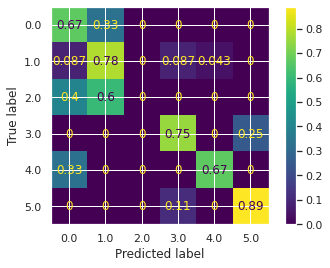

In [79]:
f_clf = RandomForestClassifier(bootstrap=False, max_depth=3, min_impurity_decrease=0, n_estimators=100, random_state=42)

f_clf.fit(pca_x_train, y_train)

fy_pred = f_clf.predict(pca_x_test)

f_accuracy_score = metrics.accuracy_score(y_test, fy_pred)

print('Forest - Accuracy score:',f_accuracy_score)
print('F1-score:',f1_score(y_test, fy_pred, average = 'macro'))
# Plotting confusion matrix
ax = plot_confusion_matrix(f_clf, pca_x_test, y_test, normalize='true')


The PCA-transformed data yields worse results for the Random Forest. 

# Support Vector Machine - M4

Using Sklearn's Support Vector Machine library and GridSearchCV.

In [80]:
param_grid = {'kernel': ['rbf','poly', 'sigmoid'], 'C': [2,30,50, 100, 200], 'random_state' : [42]}
 
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
 
# Fitting the model for grid search
svm_ = grid.fit(x_train, y_train)

grid_predictions = svm_.predict(x_val)

svm_acc_score = metrics.accuracy_score(y_val,grid_predictions)

# Print best parameter after tuning
best_parm = svm_.best_params_
print(best_parm)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END ..C=2, kernel=rbf, random_state=42;, score=0.652 total time=   0.0s
[CV 2/5] END ..C=2, kernel=rbf, random_state=42;, score=0.682 total time=   0.0s
[CV 3/5] END ..C=2, kernel=rbf, random_state=42;, score=0.409 total time=   0.0s
[CV 4/5] END ..C=2, kernel=rbf, random_state=42;, score=0.727 total time=   0.0s
[CV 5/5] END ..C=2, kernel=rbf, random_state=42;, score=0.682 total time=   0.0s
[CV 1/5] END .C=2, kernel=poly, random_state=42;, score=0.565 total time=   0.0s
[CV 2/5] END .C=2, kernel=poly, random_state=42;, score=0.682 total time=   0.0s
[CV 3/5] END .C=2, kernel=poly, random_state=42;, score=0.500 total time=   0.0s
[CV 4/5] END .C=2, kernel=poly, random_state=42;, score=0.545 total time=   0.0s
[CV 5/5] END .C=2, kernel=poly, random_state=42;, score=0.545 total time=   0.0s
[CV 1/5] END C=2, kernel=sigmoid, random_state=42;, score=0.348 total time=   0.0s
[CV 2/5] END C=2, kernel=sigmoid, random_state

F1-score: 0.4738917306052856
SVM - Accuracy score: 0.6615384615384615
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


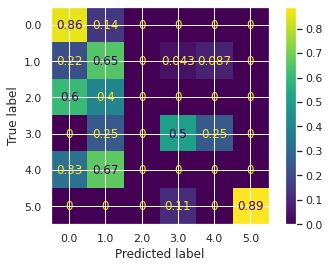

In [81]:
svm_clf = svm.SVC(kernel = 'rbf', C = 2, random_state = 42)

svm_clf.fit(x_train, y_train)

y_pred = svm_clf.predict(x_test)

svc_accuracy_score = metrics.accuracy_score(y_test, y_pred)

print('F1-score:',f1_score(y_test, y_pred, average = 'macro'))
print('SVM - Accuracy score:',svc_accuracy_score)

ax = plot_confusion_matrix(svm_clf, x_test, y_test, normalize='true');

Now we will try to use the PCA-transformed data to see if it gives better results

In [82]:
param_grid = {'kernel': ['rbf','poly', 'sigmoid'], 'C': [2,30,50, 100, 200], 'random_state' : [42]}
 
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
 
# Fitting the model for grid search
svm_ = grid.fit(pca_x_train, y_train)

grid_predictions = svm_.predict(pca_x_val)

svm_acc_score = metrics.accuracy_score(y_val,grid_predictions)

# Print best parameter after tuning
best_parm = svm_.best_params_
print(best_parm)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END ..C=2, kernel=rbf, random_state=42;, score=0.652 total time=   0.0s
[CV 2/5] END ..C=2, kernel=rbf, random_state=42;, score=0.636 total time=   0.0s
[CV 3/5] END ..C=2, kernel=rbf, random_state=42;, score=0.545 total time=   0.0s
[CV 4/5] END ..C=2, kernel=rbf, random_state=42;, score=0.591 total time=   0.0s
[CV 5/5] END ..C=2, kernel=rbf, random_state=42;, score=0.636 total time=   0.0s
[CV 1/5] END .C=2, kernel=poly, random_state=42;, score=0.478 total time=   0.0s
[CV 2/5] END .C=2, kernel=poly, random_state=42;, score=0.591 total time=   0.0s
[CV 3/5] END .C=2, kernel=poly, random_state=42;, score=0.500 total time=   0.0s
[CV 4/5] END .C=2, kernel=poly, random_state=42;, score=0.455 total time=   0.0s
[CV 5/5] END .C=2, kernel=poly, random_state=42;, score=0.500 total time=   0.0s
[CV 1/5] END C=2, kernel=sigmoid, random_state=42;, score=0.478 total time=   0.0s
[CV 2/5] END C=2, kernel=sigmoid, random_state

F1-score: 0.48842302878598254
SVM - Accuracy score: 0.6923076923076923
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


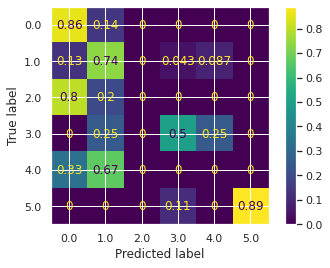

In [83]:
svm_clf = svm.SVC(kernel = 'rbf', C = 2, random_state = 42)

svm_clf.fit(pca_x_train, y_train)

y_pred = svm_clf.predict(pca_x_test)

svc_accuracy_score = metrics.accuracy_score(y_test, y_pred)

print('F1-score:',f1_score(y_test, y_pred, average = 'macro'))
print('SVM - Accuracy score:',svc_accuracy_score)

ax = plot_confusion_matrix(svm_clf, pca_x_test, y_test, normalize='true');

The PCA-transformed data gives better results.

# K-Nearest Neighbors - M5
Using Sklern's library to implemenet K-nearest neighbors and GridSearchCV

In [84]:
param_grid = {'n_neighbors' : [1,2,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],'weights': ['uniform','distance']}
 
grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True)
 
# Fitting the model for grid search
knn = grid.fit(x_train, y_train)

knn_y_pred = knn.predict(x_val)

knn_acc_score = metrics.accuracy_score(y_val,knn_y_pred)

# Print best parameter after tuning
best_parm = knn.best_params_
print(best_parm)

{'n_neighbors': 1, 'weights': 'uniform'}


F1-score: 0.6235680936767892
KNN - Accuracy score: 0.676923076923077
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


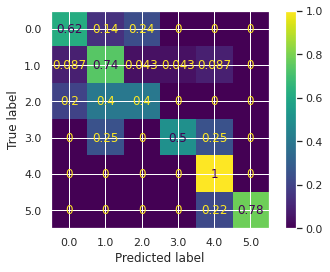

In [85]:
knn_ = KNeighborsClassifier(n_neighbors=1,weights='uniform')

knn_.fit(x_train, y_train)

k_y_pred = knn_.predict(x_test)

knn_accuracy_score = metrics.accuracy_score(y_test, k_y_pred)

print('F1-score:',f1_score(y_test, k_y_pred, average = 'macro'))
print('KNN - Accuracy score:',knn_accuracy_score)

ax = plot_confusion_matrix(knn_, x_test, y_test, normalize='true');

#### Plotting validation curve with KNN classifier

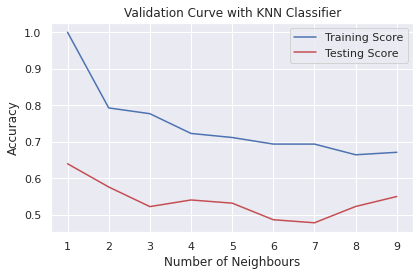

In [86]:
parameter_range = np.arange(1, 10, 1)

train_score, test_score = validation_curve(KNeighborsClassifier(), x_train, y_train,
                                       param_name = "n_neighbors",
                                       param_range = parameter_range,
                                        cv = 5, scoring = "accuracy")
 
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
plt.plot(parameter_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score,
   label = "Testing Score", color = 'r')
 
# Creating the plot
plt.title("Validation Curve with KNN Classifier")
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=debeac55-322a-4813-a231-add2ce776aa2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>